In [0]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from numpy.random import seed
import tensorflow as tf


In [0]:
seed(1)
tf.random.set_seed(2)


##Downloading the dataset

In [28]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

######################################################################## 100.0%
101_ObjectCategories  sample_data


In [29]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/ceiling_fan', '101_ObjectCategories/bass', '101_ObjectCategories/rhino', '101_ObjectCategories/Leopards', '101_ObjectCategories/schooner', '101_ObjectCategories/barrel', '101_ObjectCategories/cup', '101_ObjectCategories/water_lilly', '101_ObjectCategories/lamp', '101_ObjectCategories/windsor_chair', '101_ObjectCategories/panda', '101_ObjectCategories/soccer_ball', '101_ObjectCategories/trilobite', '101_ObjectCategories/joshua_tree', '101_ObjectCategories/scissors', '101_ObjectCategories/helicopter', '101_ObjectCategories/anchor', '101_ObjectCategories/umbrella', '101_ObjectCategories/saxophone', '101_ObjectCategories/flamingo_head', '101_ObjectCategories/buddha', '101_ObjectCategories/pigeon', '101_ObjectCategories/pyramid', '101_ObjectCategories/llama', '101_ObjectCategories/okapi', '101_ObjectCategories/nautilus', '101_ObjectCategories/cellphone', '101_ObjectCategories/octopus', '101_ObjectCategories/ketch', '101_ObjectCategories/minaret', '101_ObjectCategories

This function is useful for pre-processing the data into an image and input vector.

In [0]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Load all images from root folder

In [0]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize the data order

In [0]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [0]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Seperate data for labels

In [34]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[93, 88, 64, 28, 4, 43, 3, 40, 61, 18, 68, 30, 28, 2, 16, 88, 22, 85, 3, 42, 2, 92, 90, 0, 44, 41, 20, 23, 43, 42, 86, 3, 57, 4, 88, 44, 3, 85, 4, 68, 54, 53, 20, 68, 52, 81, 64, 48, 43, 55, 40, 29, 61, 45, 20, 26, 3, 21, 73, 29, 68, 47, 85, 2, 21, 6, 54, 31, 95, 31, 50, 17, 3, 83, 11, 66, 72, 72, 70, 72, 67, 9, 13, 92, 87, 24, 20, 17, 40, 68, 29, 32, 59, 65, 33, 56, 87, 43, 76, 57, 36, 68, 58, 19, 32, 68, 84, 50, 88, 40, 25, 92, 67, 93, 89, 54, 3, 22, 46, 32, 4, 49, 81, 40, 53, 84, 58, 36, 8, 27, 8, 60, 36, 49, 11, 54, 72, 41, 7, 79, 3, 42, 11, 50, 74, 6, 15, 65, 82, 51, 27, 55, 28, 54, 83, 42, 3, 9, 60, 33, 23, 6, 35, 1, 88, 41, 88, 53, 56, 48, 31, 3, 32, 38, 62, 88, 40, 68, 71, 13, 16, 11, 10, 57, 36, 32, 36, 36, 95, 31, 61, 8, 28, 68, 63, 22, 29, 32, 8, 68, 12, 70, 56, 63, 91, 68, 60, 87, 75, 46, 85, 93, 77, 42, 48, 5, 46, 92, 39, 14, 61, 80, 20, 31, 57, 22, 44, 31, 9, 17, 68, 45, 6, 21, 54, 89, 6, 69, 3, 17, 92, 93, 67, 68, 72, 23, 14, 1, 15, 61, 54, 25, 28, 6, 32, 89, 48, 43, 15,

Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [35]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


Let's get a summary of what we have.

In [36]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


If everything worked properly, you should have loaded a bunch of images, and split them into three sets: train, val, and test. The shape of the training data should be (n, 224, 224, 3) where n is the size of your training set, and the labels should be (n, c) where c is the number of classes (97 in the case of 101_ObjectCategories.

Notice that we divided all the data into three subsets -- a training set train, a validation set val, and a test set test. The reason for this is to properly evaluate the accuracy of our classifier. During training, the optimizer uses the validation set to evaluate its internal performance, in order to determine the gradient without overfitting to the training set. The test set is always held out from the training algorithm, and is only used at the end to evaluate the final accuracy of our model.

Let's quickly look at a few sample images from our dataset.

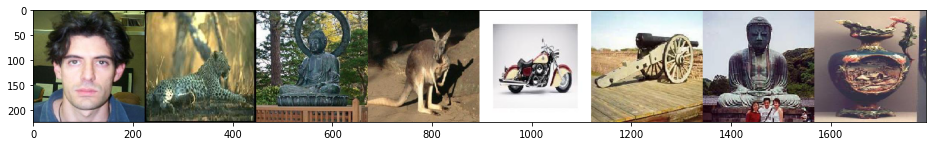

In [37]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

##CNN without dropout

The following below is a an architecture of CNN without dropout on caltech-101 dataset. It has two conv layers, two max pooling layers, one dense layer, and one flatten layer. Since, the model below is likely to produce different accuracy results. So, we have run the model three times and calculates the overall accuracy by taking their averages. 

In [38]:
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])
model.add(Conv2D(16, (3,3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(97, activation='softmax'))
model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 97)                9389697   
Total params: 9,394,785
Trainable params: 9,394,785
Non-trainable params: 0
___________

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [40]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 13s 3ms/step - loss: 4.7762 - accuracy: 0.1015 - val_loss: 3.7866 - val_accuracy: 0.2234
Epoch 2/10
4346/4346 [==============================] - 5s 1ms/step - loss: 2.5178 - accuracy: 0.4480 - val_loss: 3.0715 - val_accuracy: 0.3684
Epoch 3/10
4346/4346 [==============================] - 5s 1ms/step - loss: 1.0174 - accuracy: 0.7803 - val_loss: 2.9738 - val_accuracy: 0.3985
Epoch 4/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.2646 - accuracy: 0.9544 - val_loss: 3.5169 - val_accuracy: 0.3684
Epoch 5/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.0722 - accuracy: 0.9906 - val_loss: 4.0044 - val_accuracy: 0.3749
Epoch 6/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.0223 - accuracy: 0.9986 - val_loss: 3.7286 - val_accuracy: 0.4082
Epoch 7/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.0068 - acc

In [41]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 3.941348679587565
Test accuracy: 0.4109441936016083


In [42]:
model1 = Sequential()
print("Input dimensions: ",x_train.shape[1:])
model1.add(Conv2D(16, (3,3), activation='relu', input_shape=x_train.shape[1:]))
model1.add(Conv2D(32, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=2, strides=2))

model1.add(MaxPooling2D(pool_size=2, strides=2))
model1.add(Flatten())
model1.add(Dense(97, activation='softmax'))
model1.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 97)                9389697   
Total params: 9,394,785
Trainable params: 9,394,785
Non-trainable params: 0
___________

In [0]:
model1.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [44]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
history = model1.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 5s 1ms/step - loss: 4.6734 - accuracy: 0.1137 - val_loss: 3.6523 - val_accuracy: 0.2417
Epoch 2/10
4346/4346 [==============================] - 5s 1ms/step - loss: 2.5356 - accuracy: 0.4416 - val_loss: 3.0487 - val_accuracy: 0.3555
Epoch 3/10
4346/4346 [==============================] - 5s 1ms/step - loss: 1.1496 - accuracy: 0.7425 - val_loss: 3.0649 - val_accuracy: 0.3867
Epoch 4/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.4009 - accuracy: 0.9197 - val_loss: 3.2880 - val_accuracy: 0.3953
Epoch 5/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.1265 - accuracy: 0.9788 - val_loss: 3.4575 - val_accuracy: 0.3963
Epoch 6/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.0351 - accuracy: 0.9963 - val_loss: 3.7416 - val_accuracy: 0.3974
Epoch 7/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.0129 - accu

In [45]:
loss, accuracy1 = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy1)

Test loss: 3.8233998568784524
Test accuracy: 0.42703863978385925


In [46]:
model2 = Sequential()
print("Input dimensions: ",x_train.shape[1:])
model2.add(Conv2D(16, (3,3), activation='relu', input_shape=x_train.shape[1:]))
model2.add(Conv2D(32, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=2, strides=2))

model2.add(MaxPooling2D(pool_size=2, strides=2))
model2.add(Flatten())
model2.add(Dense(97, activation='softmax'))
model2.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 220, 220, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 97)                9389697   
Total params: 9,394,785
Trainable params: 9,394,785
Non-trainable params: 0
___________

In [0]:
model2.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [48]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
history = model2.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 5s 1ms/step - loss: 4.3583 - accuracy: 0.1325 - val_loss: 3.4731 - val_accuracy: 0.2696
Epoch 2/10
4346/4346 [==============================] - 5s 1ms/step - loss: 2.2482 - accuracy: 0.5005 - val_loss: 2.8897 - val_accuracy: 0.3931
Epoch 3/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.9324 - accuracy: 0.7945 - val_loss: 3.1306 - val_accuracy: 0.3888
Epoch 4/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.2853 - accuracy: 0.9450 - val_loss: 3.4306 - val_accuracy: 0.3867
Epoch 5/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.0767 - accuracy: 0.9899 - val_loss: 3.6995 - val_accuracy: 0.3963
Epoch 6/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.0255 - accuracy: 0.9975 - val_loss: 3.5584 - val_accuracy: 0.4178
Epoch 7/10
4346/4346 [==============================] - 5s 1ms/step - loss: 0.0087 - accu

In [49]:
loss, accuracy2 = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy2)

Test loss: 3.757632840856462
Test accuracy: 0.44420599937438965


Taking the average of three accuracies

In [0]:
overallaccuracy=(accuracy+accuracy1+accuracy2)/3

In [51]:
print("Overall accuracy: ",overallaccuracy)

Overall accuracy:  0.4273962775866191


So, the final accuracy for this model is 0.4273962775866191

##CNN with dropout

The following below is the CNN model with dropout on caltech-101 dataset. It has two conv layers, two maxpooling layers, two dense layers, one dropout and one flatten layer. As, the model is likely to produce different accuracy results, we have run the model three three times and take their averages. 

In [52]:
model_cnn_dropout = Sequential()
model_cnn_dropout = Sequential()
model_cnn_dropout.add(Conv2D(32, (3,3), activation='relu', input_shape=x_train.shape[1:]))
model_cnn_dropout.add(Conv2D(32, (3,3), activation='relu'))
model_cnn_dropout.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout.add(Flatten())
model_cnn_dropout.add(Dense(512, activation='relu'))
model_cnn_dropout.add(Dropout(0.5))
model_cnn_dropout.add(Dense(97, activation='softmax'))
model_cnn_dropout.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               49562112  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

In [0]:
model_cnn_dropout.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [54]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
history = model_cnn_dropout.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 8s 2ms/step - loss: 4.8488 - accuracy: 0.0433 - val_loss: 4.4352 - val_accuracy: 0.0773
Epoch 2/10
4346/4346 [==============================] - 7s 2ms/step - loss: 4.2616 - accuracy: 0.1015 - val_loss: 4.0160 - val_accuracy: 0.1536
Epoch 3/10
4346/4346 [==============================] - 7s 2ms/step - loss: 3.6796 - accuracy: 0.2149 - val_loss: 3.4919 - val_accuracy: 0.2718
Epoch 4/10
4346/4346 [==============================] - 7s 1ms/step - loss: 2.8748 - accuracy: 0.3509 - val_loss: 3.0619 - val_accuracy: 0.3491
Epoch 5/10
4346/4346 [==============================] - 7s 2ms/step - loss: 1.9935 - accuracy: 0.5262 - val_loss: 2.9122 - val_accuracy: 0.3759
Epoch 6/10
4346/4346 [==============================] - 7s 2ms/step - loss: 1.2505 - accuracy: 0.6845 - val_loss: 2.9199 - val_accuracy: 0.3738
Epoch 7/10
4346/4346 [==============================] - 7s 1ms/step - loss: 0.7326 - accu

In [55]:
loss, accuracydropout = model_cnn_dropout.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracydropout)

Test loss: 3.208528535048849
Test accuracy: 0.3873390555381775


In [56]:
model_cnn_dropout1 = Sequential()
model_cnn_dropout1 = Sequential()
model_cnn_dropout1.add(Conv2D(32, (3,3), activation='relu', input_shape=x_train.shape[1:]))
model_cnn_dropout1.add(Conv2D(32, (3,3), activation='relu'))
model_cnn_dropout1.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout1.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout1.add(Flatten())
model_cnn_dropout1.add(Dense(512, activation='relu'))
model_cnn_dropout1.add(Dropout(0.5))
model_cnn_dropout1.add(Dense(97, activation='softmax'))
model_cnn_dropout1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               49562112  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [0]:
model_cnn_dropout1.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [58]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
history = model_cnn_dropout1.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 7s 2ms/step - loss: 4.9246 - accuracy: 0.0391 - val_loss: 4.4739 - val_accuracy: 0.0473
Epoch 2/10
4346/4346 [==============================] - 6s 1ms/step - loss: 4.3909 - accuracy: 0.0688 - val_loss: 4.2046 - val_accuracy: 0.1053
Epoch 3/10
4346/4346 [==============================] - 6s 1ms/step - loss: 3.9655 - accuracy: 0.1461 - val_loss: 3.7038 - val_accuracy: 0.2170
Epoch 4/10
4346/4346 [==============================] - 7s 2ms/step - loss: 3.1454 - accuracy: 0.2966 - val_loss: 3.1502 - val_accuracy: 0.3233
Epoch 5/10
4346/4346 [==============================] - 7s 1ms/step - loss: 2.2093 - accuracy: 0.4795 - val_loss: 2.9169 - val_accuracy: 0.3545
Epoch 6/10
4346/4346 [==============================] - 7s 2ms/step - loss: 1.3935 - accuracy: 0.6583 - val_loss: 2.8504 - val_accuracy: 0.3716
Epoch 7/10
4346/4346 [==============================] - 7s 2ms/step - loss: 0.8400 - accu

In [59]:
loss, accuracydroput1 = model_cnn_dropout1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracydroput1)

Test loss: 3.299062753439973
Test accuracy: 0.3798283338546753


In [60]:
model_cnn_dropout2 = Sequential()
model_cnn_dropout2 = Sequential()
model_cnn_dropout2.add(Conv2D(32, (3,3), activation='relu', input_shape=x_train.shape[1:]))
model_cnn_dropout2.add(Conv2D(32, (3,3), activation='relu'))
model_cnn_dropout2.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout2.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout2.add(Flatten())
model_cnn_dropout2.add(Dense(512, activation='relu'))
model_cnn_dropout2.add(Dropout(0.5))
model_cnn_dropout2.add(Dense(97, activation='softmax'))
model_cnn_dropout2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               49562112  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)             

In [0]:
model_cnn_dropout2.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [62]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
history = model_cnn_dropout2.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 7s 2ms/step - loss: 5.3036 - accuracy: 0.0396 - val_loss: 4.4886 - val_accuracy: 0.0612
Epoch 2/10
4346/4346 [==============================] - 6s 1ms/step - loss: 4.4085 - accuracy: 0.0690 - val_loss: 4.1922 - val_accuracy: 0.1224
Epoch 3/10
4346/4346 [==============================] - 7s 2ms/step - loss: 3.9259 - accuracy: 0.1526 - val_loss: 3.6906 - val_accuracy: 0.2062
Epoch 4/10
4346/4346 [==============================] - 7s 1ms/step - loss: 3.1668 - accuracy: 0.2897 - val_loss: 3.3009 - val_accuracy: 0.2965
Epoch 5/10
4346/4346 [==============================] - 7s 2ms/step - loss: 2.3551 - accuracy: 0.4455 - val_loss: 3.0195 - val_accuracy: 0.3426
Epoch 6/10
4346/4346 [==============================] - 7s 2ms/step - loss: 1.5686 - accuracy: 0.6079 - val_loss: 2.9607 - val_accuracy: 0.3749
Epoch 7/10
4346/4346 [==============================] - 7s 1ms/step - loss: 0.9492 - accu

In [63]:
loss, accuracydroput2 = model_cnn_dropout2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracydroput2)

Test loss: 3.4517512270309383
Test accuracy: 0.3755364716053009


In [0]:
overallaccuracydropout=(accuracydropout+accuracydroput1+accuracydroput2)/3

In [65]:
print(overallaccuracydropout)

0.3809012869993846


The overall accuracy for this model is 0.3809012869993846

It is always expected that the model with dropout performs better than the model without dropout. But, in our experiment, we have found the opposite of that. The overall accuracy of the model without dropout is 0.4273962775866191, and,the overall accuracy of the model with dropout is 0.389012869993846. So, the model without dropot performs better than the model with dropout.

##Transfer learning with Resnet50version2

The following below is the application of transfer learning to a pretrained network. We are using ResNet50V2 to train our model. We have trained our model in two ways. One is freezing all the layers except the last layer, and another is unfreezing extra layer.

The following below is the code for freezing all the layers except the last one.

In [66]:
vgg = keras.applications.ResNet50V2(weights='imagenet', include_top=True)
vgg.summary()

102875136/102869336 [==============================] - 3s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________

In [0]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [68]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [69]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 16s 4ms/step - loss: 2.7422 - accuracy: 0.4390 - val_loss: 0.9096 - val_accuracy: 0.7691
Epoch 2/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.6481 - accuracy: 0.8902 - val_loss: 0.5005 - val_accuracy: 0.8550
Epoch 3/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.3270 - accuracy: 0.9524 - val_loss: 0.4098 - val_accuracy: 0.8786
Epoch 4/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.2096 - accuracy: 0.9756 - val_loss: 0.3806 - val_accuracy: 0.8851
Epoch 5/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1462 - accuracy: 0.9871 - val_loss: 0.3638 - val_accuracy: 0.8872
Epoch 6/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1065 - accuracy: 0.9952 - val_loss: 0.3400 - val_accuracy: 0.8937
Epoch 7/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0827

In [70]:
loss, accuracyfreeze = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyfreeze)

Test loss: 0.4120478233554333
Test accuracy: 0.8884119987487793


In [0]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new1 = Model(inp, out)

In [72]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new1.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new1.layers[-1:]):
    layer.trainable = True

model_new1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [73]:
history2 = model_new1.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 14s 3ms/step - loss: 2.7437 - accuracy: 0.4399 - val_loss: 0.8463 - val_accuracy: 0.7981
Epoch 2/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.6541 - accuracy: 0.8863 - val_loss: 0.4563 - val_accuracy: 0.8679
Epoch 3/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.3244 - accuracy: 0.9489 - val_loss: 0.3801 - val_accuracy: 0.8915
Epoch 4/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.2088 - accuracy: 0.9735 - val_loss: 0.3464 - val_accuracy: 0.8947
Epoch 5/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1420 - accuracy: 0.9896 - val_loss: 0.3216 - val_accuracy: 0.9044
Epoch 6/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1095 - accuracy: 0.9947 - val_loss: 0.3118 - val_accuracy: 0.9055
Epoch 7/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0809

In [74]:
loss, accuracyfreeze1 = model_new1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyfreeze1)

Test loss: 0.3912686813031143
Test accuracy: 0.8884119987487793


In [0]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new2 = Model(inp, out)

In [76]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new2.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new2.layers[-1:]):
    layer.trainable = True

model_new2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [77]:
history2 = model_new2.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 14s 3ms/step - loss: 2.8310 - accuracy: 0.4100 - val_loss: 0.8977 - val_accuracy: 0.7787
Epoch 2/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.6732 - accuracy: 0.8902 - val_loss: 0.4783 - val_accuracy: 0.8700
Epoch 3/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.3405 - accuracy: 0.9450 - val_loss: 0.3924 - val_accuracy: 0.8808
Epoch 4/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.2145 - accuracy: 0.9740 - val_loss: 0.3488 - val_accuracy: 0.8904
Epoch 5/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1483 - accuracy: 0.9864 - val_loss: 0.3309 - val_accuracy: 0.8980
Epoch 6/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1125 - accuracy: 0.9924 - val_loss: 0.3209 - val_accuracy: 0.8980
Epoch 7/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0844

In [78]:
loss, accuracyfreeze2 = model_new2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyfreeze2)

Test loss: 0.3894257926633941
Test accuracy: 0.8905579447746277


In [0]:
overallaccuracyfreeze=(accuracyfreeze+accuracyfreeze1+accuracyfreeze2)/3

In [80]:
print("Overall accuracy score",overallaccuracyfreeze)

Overall accuracy score 0.8891273140907288


The overall accuracy score for freezing all the layers except the last one is 0.8891273140907288

##Unfreezing extra layer

In [0]:
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new3 = Model(inp, out)

In [82]:
# Unfreezing extra layer
for l, layer in enumerate(model_new3.layers[:-2]):
    layer.trainable = False


for l, layer in enumerate(model_new3.layers[-2:]):
    layer.trainable = True

model_new3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [83]:
history3 = model_new3.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 14s 3ms/step - loss: 2.7126 - accuracy: 0.4512 - val_loss: 0.8414 - val_accuracy: 0.7991
Epoch 2/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.6650 - accuracy: 0.8896 - val_loss: 0.4881 - val_accuracy: 0.8647
Epoch 3/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.3381 - accuracy: 0.9462 - val_loss: 0.3812 - val_accuracy: 0.8915
Epoch 4/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.2140 - accuracy: 0.9728 - val_loss: 0.3679 - val_accuracy: 0.8937
Epoch 5/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1499 - accuracy: 0.9871 - val_loss: 0.3348 - val_accuracy: 0.9044
Epoch 6/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1109 - accuracy: 0.9929 - val_loss: 0.3301 - val_accuracy: 0.9066
Epoch 7/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0846

In [84]:
loss, accuracyunfreeze = model_new3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyunfreeze)

Test loss: 0.42487703039922425
Test accuracy: 0.8873390555381775


In [0]:
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new4 = Model(inp, out)

In [86]:
# Unfreezing extra layer
for l, layer in enumerate(model_new4.layers[:-2]):
    layer.trainable = False


for l, layer in enumerate(model_new4.layers[-2:]):
    layer.trainable = True

model_new4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new4.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [87]:
history4 = model_new4.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 14s 3ms/step - loss: 2.7033 - accuracy: 0.4409 - val_loss: 0.8570 - val_accuracy: 0.7744
Epoch 2/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.6511 - accuracy: 0.8898 - val_loss: 0.4614 - val_accuracy: 0.8797
Epoch 3/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.3353 - accuracy: 0.9489 - val_loss: 0.3801 - val_accuracy: 0.8937
Epoch 4/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.2096 - accuracy: 0.9735 - val_loss: 0.3387 - val_accuracy: 0.9012
Epoch 5/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1454 - accuracy: 0.9869 - val_loss: 0.3193 - val_accuracy: 0.9055
Epoch 6/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1091 - accuracy: 0.9947 - val_loss: 0.3124 - val_accuracy: 0.9066
Epoch 7/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0825

In [88]:
loss, accuracyunfreeze1 = model_new4.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyunfreeze1)

Test loss: 0.420931550310405
Test accuracy: 0.8905579447746277


In [0]:
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new5 = Model(inp, out)

In [90]:
# Unfreezing extra layer
for l, layer in enumerate(model_new5.layers[:-2]):
    layer.trainable = False


for l, layer in enumerate(model_new5.layers[-2:]):
    layer.trainable = True

model_new5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new5.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [91]:
history5 = model_new5.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 14s 3ms/step - loss: 2.7114 - accuracy: 0.4533 - val_loss: 0.8878 - val_accuracy: 0.7863
Epoch 2/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.6573 - accuracy: 0.8974 - val_loss: 0.4811 - val_accuracy: 0.8754
Epoch 3/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.3324 - accuracy: 0.9480 - val_loss: 0.4065 - val_accuracy: 0.8926
Epoch 4/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.2097 - accuracy: 0.9765 - val_loss: 0.3655 - val_accuracy: 0.9012
Epoch 5/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1480 - accuracy: 0.9878 - val_loss: 0.3507 - val_accuracy: 0.8926
Epoch 6/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1081 - accuracy: 0.9952 - val_loss: 0.3398 - val_accuracy: 0.9087
Epoch 7/10
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0836

In [92]:
loss, accuracyunfreeze2 = model_new5.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyunfreeze2)

Test loss: 0.41861668791893725
Test accuracy: 0.8873390555381775


In [0]:
overallaccuracyunfreeze=(accuracyunfreeze+accuracyunfreeze1+accuracyunfreeze2)/3

In [94]:
print("Overall accuracy of unfreezing extra layer",overallaccuracyunfreeze)

Overall accuracy of unfreezing extra layer 0.8884120186169943


The overall accuracy of unfreezing extra layer is 0.884120186169943

From our experiment, it can witnessed that the accuracy of freezing all the layers except the last layer is higher than the accuracy of unfreezing extra layer. The accuracy of freezing all the layers except the last layer is 0.8891273140907288, and, the accuracy of unfreezing extra layer is 0.884120186169943. So, transfer learning with freezing all the layers works better on Caltech-101 dataset than unfreezing extra layer. In comparison with other two models i.e. CNN without dropout and with dropout, both versions of transfer learning work better, as the accuracy of CNN without droupoout is 0.4273962775866191, the accuracy of CNN with dropout is 0.3809012869993846.

Transfer learning with Data augmentation. I have used image data generator as data augmentation.

The following below is the application of data augmentation with transfer learning where all the layers are frozen except the last layer. 

In [95]:
vgg = keras.applications.ResNet50V2(weights='imagenet', include_top=True)
vgg.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [0]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
modelnew6 = Model(inp, out)

In [97]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(modelnew6.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(modelnew6.layers[-1:]):
    layer.trainable = True

modelnew6.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelnew6.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

I have used image datagenerator as data augmentation. The following below is the application of data augmentation in transfer learning where all the layers are frozen except the last layer

In [0]:
import tensorflow as tf

In [99]:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [102]:
# fits the model on batches with real-time data augmentation:
modelnew6.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=10)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


136/135 [==============================] - 44s 327ms/step - loss: 2.0190 - accuracy: 0.5775
Epoch 2/10
136/135 [==============================] - 44s 322ms/step - loss: 0.6162 - accuracy: 0.8603
Epoch 3/10
136/135 [==============================] - 44s 321ms/step - loss: 0.4200 - accuracy: 0.8997
Epoch 4/10
136/135 [==============================] - 44s 320ms/step - loss: 0.3116 - accuracy: 0.9264
Epoch 5/10
136/135 [==============================] - 43s 319ms/step - loss: 0.2548 - accuracy: 0.9409
Epoch 6/10
136/135 [==============================] - 43s 319ms/step - loss: 0.2217 - accuracy: 0.9441
Epoch 7/10
136/135 [==============================] - 44s 320ms/step - loss: 0.1772 - accuracy: 0.9588
Epoch 8/10
136/135 [==============================] - 43s 318ms/step - loss: 0.1619 - accuracy: 0.9611
Epoch 9/10
136/135 [==============================] - 44s 320ms/step - loss: 0.1556 - accuracy: 0.9595
Epoch 10/10
136/135 [==============================] - 44s 320ms/step - loss: 0.1203

In [103]:
loss, accuracyfreeze3 = modelnew6.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyfreeze3)

Test loss: 0.43040064786253057
Test accuracy: 0.8937768340110779


In [0]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
modelnew7 = Model(inp, out)

In [105]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(modelnew7.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(modelnew7.layers[-1:]):
    layer.trainable = True

modelnew7.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelnew7.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
import tensorflow as tf

In [107]:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [110]:
# fits the model on batches with real-time data augmentation:
modelnew7.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=10)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


136/135 [==============================] - 44s 322ms/step - loss: 2.0522 - accuracy: 0.5695
Epoch 2/10
136/135 [==============================] - 43s 319ms/step - loss: 0.6164 - accuracy: 0.8603
Epoch 3/10
136/135 [==============================] - 43s 316ms/step - loss: 0.4289 - accuracy: 0.8988
Epoch 4/10
136/135 [==============================] - 43s 319ms/step - loss: 0.3151 - accuracy: 0.9245
Epoch 5/10
136/135 [==============================] - 43s 318ms/step - loss: 0.2542 - accuracy: 0.9344
Epoch 6/10
136/135 [==============================] - 43s 318ms/step - loss: 0.2312 - accuracy: 0.9455
Epoch 7/10
136/135 [==============================] - 43s 317ms/step - loss: 0.1867 - accuracy: 0.9551
Epoch 8/10
136/135 [==============================] - 43s 318ms/step - loss: 0.1628 - accuracy: 0.9607
Epoch 9/10
136/135 [==============================] - 43s 318ms/step - loss: 0.1446 - accuracy: 0.9669
Epoch 10/10
136/135 [==============================] - 43s 316ms/step - loss: 0.1258

In [111]:
loss, accuracyfreeze4 = modelnew7.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyfreeze4)

Test loss: 0.47705480962384156
Test accuracy: 0.8969957232475281


In [0]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
modelnew8 = Model(inp, out)

In [113]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(modelnew8.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(modelnew8.layers[-1:]):
    layer.trainable = True

modelnew8.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelnew8.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
import tensorflow as tf

In [115]:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [118]:
# fits the model on batches with real-time data augmentation:
modelnew8.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=10)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


136/135 [==============================] - 44s 320ms/step - loss: 1.9882 - accuracy: 0.5879
Epoch 2/10
136/135 [==============================] - 43s 320ms/step - loss: 0.6272 - accuracy: 0.8557
Epoch 3/10
136/135 [==============================] - 43s 317ms/step - loss: 0.4284 - accuracy: 0.8932
Epoch 4/10
136/135 [==============================] - 43s 320ms/step - loss: 0.3118 - accuracy: 0.9234
Epoch 5/10
136/135 [==============================] - 43s 318ms/step - loss: 0.2562 - accuracy: 0.9390
Epoch 6/10
136/135 [==============================] - 43s 319ms/step - loss: 0.2199 - accuracy: 0.9473
Epoch 7/10
136/135 [==============================] - 43s 316ms/step - loss: 0.1810 - accuracy: 0.9556
Epoch 8/10
136/135 [==============================] - 43s 318ms/step - loss: 0.1577 - accuracy: 0.9618
Epoch 9/10
136/135 [==============================] - 44s 320ms/step - loss: 0.1528 - accuracy: 0.9636
Epoch 10/10
136/135 [==============================] - 43s 317ms/step - loss: 0.1340

In [119]:
loss, accuracyfreeze5 = modelnew8.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyfreeze5)

Test loss: 0.48436556775682477
Test accuracy: 0.8980686664581299


In [0]:
overallaccuracyfreezeaugmentation=(accuracyfreeze3+accuracyfreeze4+accuracyfreeze5)/3

In [121]:
print("Overall accuracy",overallaccuracyfreezeaugmentation)

Overall accuracy 0.8962804079055786


The overall accuracy of data augmentation with freezing all the layers except the last one is 0.8962804079055786 which is higher than the transfer learning with freezing all the layers except the last one is 0.8891273140907288. So, applying data augmentation makes the model more accurate.

##Data augmentation for unfreezing extra layer

In [0]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
modelnew9 = Model(inp, out)

In [124]:
# Unfreezing extra layer
for l, layer in enumerate(modelnew9.layers[:-2]):
    layer.trainable = False


for l, layer in enumerate(modelnew9.layers[-2:]):
    layer.trainable = True

modelnew9.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelnew9.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
import tensorflow as tf

In [126]:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [129]:
# fits the model on batches with real-time data augmentation:
modelnew9.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=10)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


136/135 [==============================] - 45s 327ms/step - loss: 2.0715 - accuracy: 0.5681
Epoch 2/10
136/135 [==============================] - 44s 321ms/step - loss: 0.6178 - accuracy: 0.8619
Epoch 3/10
136/135 [==============================] - 43s 318ms/step - loss: 0.4231 - accuracy: 0.9004
Epoch 4/10
136/135 [==============================] - 43s 317ms/step - loss: 0.3226 - accuracy: 0.9202
Epoch 5/10
136/135 [==============================] - 44s 320ms/step - loss: 0.2586 - accuracy: 0.9402
Epoch 6/10
136/135 [==============================] - 44s 320ms/step - loss: 0.2346 - accuracy: 0.9367
Epoch 7/10
136/135 [==============================] - 43s 318ms/step - loss: 0.1910 - accuracy: 0.9531
Epoch 8/10
136/135 [==============================] - 43s 319ms/step - loss: 0.1576 - accuracy: 0.9613
Epoch 9/10
136/135 [==============================] - 43s 319ms/step - loss: 0.1450 - accuracy: 0.9623
Epoch 10/10
136/135 [==============================] - 43s 317ms/step - loss: 0.1439

In [130]:
loss, accuracyunfreeze3 = modelnew9.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyunfreeze3)

Test loss: 0.4762027018379756
Test accuracy: 0.8841201663017273


In [0]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
modelnew10 = Model(inp, out)

In [132]:
# Unfreezing extra layer
for l, layer in enumerate(modelnew10.layers[:-2]):
    layer.trainable = False


for l, layer in enumerate(modelnew10.layers[-2:]):
    layer.trainable = True

modelnew10.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelnew10.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
import tensorflow as tf

In [134]:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [137]:
# fits the model on batches with real-time data augmentation:
modelnew10.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=10)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


136/135 [==============================] - 44s 325ms/step - loss: 2.0040 - accuracy: 0.5785
Epoch 2/10
136/135 [==============================] - 43s 319ms/step - loss: 0.6171 - accuracy: 0.8587
Epoch 3/10
136/135 [==============================] - 44s 320ms/step - loss: 0.4111 - accuracy: 0.9022
Epoch 4/10
136/135 [==============================] - 43s 318ms/step - loss: 0.3354 - accuracy: 0.9206
Epoch 5/10
136/135 [==============================] - 43s 318ms/step - loss: 0.2625 - accuracy: 0.9347
Epoch 6/10
136/135 [==============================] - 43s 318ms/step - loss: 0.2230 - accuracy: 0.9441
Epoch 7/10
136/135 [==============================] - 43s 319ms/step - loss: 0.1857 - accuracy: 0.9581
Epoch 8/10
136/135 [==============================] - 43s 319ms/step - loss: 0.1712 - accuracy: 0.9551
Epoch 9/10
136/135 [==============================] - 43s 318ms/step - loss: 0.1452 - accuracy: 0.9653
Epoch 10/10
136/135 [==============================] - 43s 319ms/step - loss: 0.1287

In [138]:
loss, accuracyunfreeze4 = modelnew10.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyunfreeze4)

Test loss: 0.4775687677250144
Test accuracy: 0.8819742202758789


In [0]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
modelnew11 = Model(inp, out)

In [140]:
# Unfreezing extra layer
for l, layer in enumerate(modelnew11.layers[:-2]):
    layer.trainable = False


for l, layer in enumerate(modelnew11.layers[-2:]):
    layer.trainable = True

modelnew11.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelnew11.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
import tensorflow as tf

In [143]:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [146]:
# fits the model on batches with real-time data augmentation:
modelnew11.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=10)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


136/135 [==============================] - 45s 330ms/step - loss: 2.0336 - accuracy: 0.5750
Epoch 2/10
136/135 [==============================] - 44s 321ms/step - loss: 0.6361 - accuracy: 0.8543
Epoch 3/10
136/135 [==============================] - 44s 323ms/step - loss: 0.4264 - accuracy: 0.8960
Epoch 4/10
136/135 [==============================] - 44s 322ms/step - loss: 0.3190 - accuracy: 0.9220
Epoch 5/10
136/135 [==============================] - 44s 323ms/step - loss: 0.2628 - accuracy: 0.9347
Epoch 6/10
136/135 [==============================] - 44s 323ms/step - loss: 0.2184 - accuracy: 0.9450
Epoch 7/10
136/135 [==============================] - 44s 323ms/step - loss: 0.1887 - accuracy: 0.9549
Epoch 8/10
136/135 [==============================] - 44s 325ms/step - loss: 0.1687 - accuracy: 0.9623
Epoch 9/10
136/135 [==============================] - 44s 322ms/step - loss: 0.1429 - accuracy: 0.9669
Epoch 10/10
136/135 [==============================] - 44s 322ms/step - loss: 0.1337

In [147]:
loss, accuracyunfreeze5 = modelnew10.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracyunfreeze5)

Test loss: 0.4775687677250144
Test accuracy: 0.8819742202758789


In [0]:
overallaccuracyunfreezeaugmentation=(accuracyunfreeze3+accuracyunfreeze4+accuracyunfreeze5)/3

In [149]:
print("Overall accuracy is",overallaccuracyunfreezeaugmentation)

Overall accuracy is 0.8826895356178284


The overall accuracy of data augmentation with unfreezing extra layer is 0.8826895356178284 which is less than 0.8884120186169943. So, the data augmentation does not improve the accuracy score for transfer learning with unfreezing extra layer.

In conclusion, the data augmentation for transfer learning with freezing all the layers works the best in caltech-101 among all the models, as it has the highest accuracy which is 0.8962804079055786.